In [24]:
import tensorflow as tf
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop

In [2]:
dataset=pd.read_csv("train.csv")
dataset.isna().sum()
dataset=dataset.fillna("Missing")

In [3]:
#cleaning the string
def clean_str(string):
    string = re.sub(r'http\S+', 'link', string) # replace links by generic text link
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)

    cleanr = re.compile('<.*?>')

    string = re.sub(r'\d+', '', string)
    string = re.sub(cleanr, '', string)
    string = re.sub("'", '', string)
    string = re.sub(r'\W+', ' ', string)
    string = string.replace('_', '')

    return string.strip().lower()

In [4]:
#Removing the stop words
stop_words = set(stopwords.words('english'))

def remove_stopwords(word_list):
    no_stop_words = [w for w in word_list if not w in stop_words]
    return no_stop_words

In [5]:
sentences=[]
text=dataset.text
labels=[]
for row in text:
    #print(row)
    row=clean_str(row)
    #print(row)
    wo_stop=remove_stopwords(row.split(" "))
    wo_stop=" ".join(wo_stop)
    #print(wo_stop+"\n\n\n")
    sentences.append(wo_stop)
for label in dataset.target:
    labels.append(label)
#print(sentences)
print(len(sentences))
print(len(labels))

7613
7613


In [13]:
#hyperparameters
train_ratio=0.7
vocab_size=10000
embedding_dim=32
max_length=32
trunc_type='post'
oov_tok="<OOV>"
batch_size=128
train_size=int(len(sentences)*0.7)
print(train_size)

5329


In [14]:
train_sentences=sentences[0:train_size]
train_labels=labels[0:train_size]
val_sentences=sentences[train_size:]
val_labels=labels[train_size:]

In [15]:
train_tokenizer=Tokenizer(num_words=vocab_size, oov_token=oov_tok)
train_tokenizer.fit_on_texts(train_sentences)
train_sequences=train_tokenizer.texts_to_sequences(train_sentences)
train_padded=pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)

val_sequences=train_tokenizer.texts_to_sequences(val_sentences)
val_padded=pad_sequences(val_sequences, maxlen=max_length, truncating=trunc_type)

In [16]:
X_train=np.array(train_padded)
y_train=np.array(train_labels)
X_val=np.array(val_padded)
y_val=np.array(val_labels)

In [17]:
model=tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.SpatialDropout1D(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, recurrent_dropout=0.5)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 32)            320000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 32, 32)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                16640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               33280     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 370,433
Trainable params: 370,433
Non-trainable params: 0
________________________________________________

In [18]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs=15
history=model.fit(X_train,y_train, epochs=num_epochs,batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/15
42/42 [==============================] - 4s 86ms/step - loss: 0.6779 - accuracy: 0.5763 - val_loss: 0.6637 - val_accuracy: 0.5582
Epoch 2/15
42/42 [==============================] - 3s 73ms/step - loss: 0.5546 - accuracy: 0.7288 - val_loss: 0.5268 - val_accuracy: 0.7553
Epoch 3/15
42/42 [==============================] - 3s 71ms/step - loss: 0.3614 - accuracy: 0.8518 - val_loss: 0.4914 - val_accuracy: 0.7719
Epoch 4/15
42/42 [==============================] - 3s 71ms/step - loss: 0.2715 - accuracy: 0.8949 - val_loss: 0.5232 - val_accuracy: 0.7644
Epoch 5/15
42/42 [==============================] - 3s 73ms/step - loss: 0.2193 - accuracy: 0.9225 - val_loss: 0.5742 - val_accuracy: 0.7680
Epoch 6/15
42/42 [==============================] - 3s 78ms/step - loss: 0.1731 - accuracy: 0.9358 - val_loss: 0.6368 - val_accuracy: 0.7430
Epoch 7/15
42/42 [==============================] - 4s 103ms/step - loss: 0.1444 - accuracy: 0.9493 - val_loss: 0.6728 - val_accuracy: 0.7421
Epoch 8/15
4

In [19]:
def plot_graphs(history,string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()


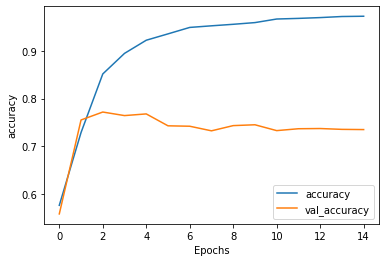

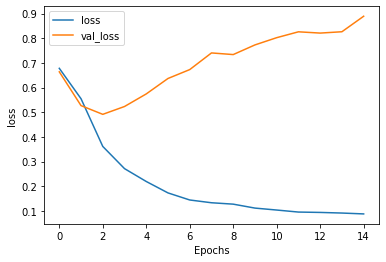

In [20]:
plot_graphs(history, "accuracy")
plot_graphs(history,"loss")

In [27]:
model=tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.SpatialDropout1D(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, recurrent_dropout=0.5)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
optimizer = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)
    
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
num_epochs=45
history=model.fit(X_train,y_train, epochs=num_epochs,batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/45
42/42 [==============================] - 4s 84ms/step - loss: 0.6891 - accuracy: 0.5695 - val_loss: 0.6878 - val_accuracy: 0.5582
Epoch 2/45
42/42 [==============================] - 3s 75ms/step - loss: 0.6836 - accuracy: 0.5755 - val_loss: 0.6852 - val_accuracy: 0.5582
Epoch 3/45
42/42 [==============================] - 3s 75ms/step - loss: 0.6807 - accuracy: 0.5755 - val_loss: 0.6840 - val_accuracy: 0.5582
Epoch 4/45
42/42 [==============================] - 3s 76ms/step - loss: 0.6789 - accuracy: 0.5755 - val_loss: 0.6826 - val_accuracy: 0.5582
Epoch 5/45
42/42 [==============================] - 3s 76ms/step - loss: 0.6759 - accuracy: 0.5755 - val_loss: 0.6803 - val_accuracy: 0.5582
Epoch 6/45
42/42 [==============================] - 3s 75ms/step - loss: 0.6719 - accuracy: 0.5755 - val_loss: 0.6766 - val_accuracy: 0.5582
Epoch 7/45
42/42 [==============================] - 3s 78ms/step - loss: 0.6668 - accuracy: 0.5755 - val_loss: 0.6716 - val_accuracy: 0.5582
Epoch 8/45
42

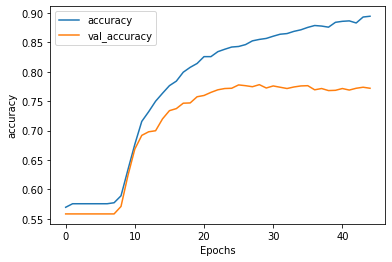

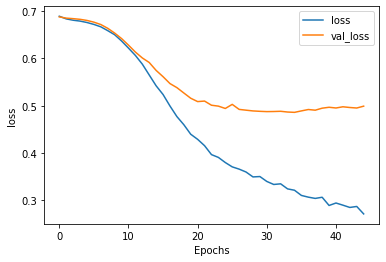

In [28]:
plot_graphs(history, "accuracy")
plot_graphs(history,"loss")

In [29]:
test=pd.read_csv("test.csv")
test_sentences=[]
text=test.text
for row in text:
    #print(row)
    row=clean_str(row)
    #print(row)
    wo_stop=remove_stopwords(row.split(" "))
    wo_stop=" ".join(wo_stop)
    #print(wo_stop+"\n\n\n")
    test_sentences.append(wo_stop)
test_sequences=train_tokenizer.texts_to_sequences(test_sentences)
test_padded=pad_sequences(test_sequences, maxlen=max_length, truncating=trunc_type)
X_test=np.array(test_padded)

In [32]:
y_pred=model.predict(X_test)
y_pred

array([[0.3835119 ],
       [0.87791646],
       [0.9439733 ],
       ...,
       [0.9132673 ],
       [0.9759361 ],
       [0.92060125]], dtype=float32)

In [33]:
predictions=[]
for i in y_pred:
    if i>0.5:
        predictions.append(1)
        
    else:
        predictions.append(0)
predictions=np.array(predictions)
predictions

array([0, 1, 1, ..., 1, 1, 1])

In [34]:
np.savetxt('submission.csv', 
           np.c_[test.id,predictions], 
           delimiter=',', 
           header = 'id,target', 
           comments = '', 
           fmt='%d')